In [1]:
# Author: Umut Mehmet ERDEM - 2024

import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft 

"""
@brief Writes image data to a file in PGM format (P2 or P5).
@param1 magicnum: Magic number representing the PGM format (P2 for ASCII, P5 for binary).
@param2 filename: Path of the file to write the image data.
@param3 width: Width of the image.
@param4 height: Height of the image.
@param5 maxval: Maximum pixel value.
@param6 data: 2D list containing the image pixel data.
@retval None
"""
def mypgmwrite(magicnum, filename, width, height, maxval, data):
    with open(filename, 'wb') as f:
        f.write(f'{magicnum}\n#{filename}\n{width} {height}\n{maxval}\n'.encode())
        for row in data:
            for i in row: f.write(bytes([int(i)])) if magicnum == "P5" else f.write(f"{int(i)} ".encode())
            if magicnum == "P2": f.write('\n'.encode())

"""
@brief Reads image data from a PGM file (P2 or P5).
@param1 filename: Path of the file to read the image data from.
@retval magicnum: Magic number representing the PGM format (P2 for ASCII, P5 for binary).
@retval width: Width of the image.
@retval height: Height of the image.
@retval maxval: Maximum pixel value.
@retval data: 2D list containing the image pixel data.
"""
def mypgmread(filename):
    with open(filename, 'rb') as f:

        def read_and_cntrl():
            line = f.readline().strip()
            while line.startswith(b'#'):
                line = f.readline().strip()
            return line
        
        magicnum = read_and_cntrl()
        width, height = map(int, read_and_cntrl().split())
        maxval = int(read_and_cntrl())

        data = []
        if magicnum == b'P5':
            for i in range(height):
                data.append(list(f.read(width)))
        else:
            for i in range(height):
                data.append(list(map(int, read_and_cntrl().split())))

        print(f"{magicnum}\n{width} {height}\n{maxval}")
        for i in data: print(*i, sep=" ")
        return magicnum, width, height, maxval, data
    
"""
@brief Modifies the pixel values of a 2D list.
@param1 data: 2D list containing the image pixel data.
@param2 start_row: Starting row index.
@param3 end_row: Ending row index.
@param4 start_col: Starting column index.
@param5 end_col: Ending column index.
@param6 new_value: New pixel value.
@retval data: 2D list containing the modified image pixel data.
"""
def modify_pixels(data, start_row, end_row, start_col, end_col, new_value):
    for i in range(start_row, end_row + 1):
        for j in range(start_col, end_col + 1):
            data[i][j] = new_value
    return data

"""
@brief Creates the negative of an image by modifying the pixel values of a 2D list.
@param1 maxval: Maximum pixel value.
@param2 data: 2D list containing the image pixel data.
@retval f_negative: 2D list containing the negative image pixel data.
"""
def myImageNegative(maxval, data):
    f_negative = []
    for i in range(len(data)):
        f_negative.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_negative[i][j] = maxval - data[i][j]
    return f_negative

"""
@brief Normalizes the pixel values of a 2D list to the range [0, 255].
@param1 data: 2D list containing the image pixel data.
@retval normalized_data: 2D list containing the normalized image pixel data.
"""
def normalize(data):
    min_val, max_val = np.min(data), np.max(data)
    normalized_data = [[np.uint8((i-min_val)/(max_val-min_val)*255) for i in row] for row in data]
    return normalized_data

"""
@brief Applies logarithmic transformation to the given image data.
@param1 c: Constant value for the transformation.
@param2 data: 2D list containing the image pixel data.
@retval f_logTransformation: 2D list containing the transformed image pixel data.
"""
def myLogTransformation(c, data):
    f_logTransformation = []
    for i in range(len(data)):
        f_logTransformation.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_logTransformation[i][j] = c*np.log(1+data[i][j])
    
    f_logTransformation = normalize(f_logTransformation)
    return f_logTransformation

"""
@brief Applies gamma transformation to the given image data.
@param1 c: Constant value for the transformation.
@param2 gamma_val: Gamma value for the transformation.
@param3 data: 2D list containing the image pixel data.
@retval f_gammaTransformation: 2D list containing the transformed image pixel data.
"""
def myGammaTransformation(c, gamma_val, data):
    f_gammaTransformation = []
    for i in range(len(data)):
        f_gammaTransformation.append([0] * len(data[i]))
        for j in range(len(data[i])):
            f_gammaTransformation[i][j] = c*(data[i][j]**gamma_val)
    
    f_gammaTransformation = normalize(f_gammaTransformation)
    return f_gammaTransformation

"""
@brief Applies correlation operation on the given image data using the provided kernel.
@param1 kernel: 2D list containing the kernel values.
@param2 data: 2D list containing the image pixel data.
@param3 avarage: if set to 1, the kernel is averaged.
@param4 normalization: if set to 1, the resulting image is normalized.
@retval f_correlation: 2D list containing the correlated image pixel data.
"""
def myImageCorrelation(kernel, data, avarage=1, normalization=1):
    x_kernel, y_kernel = np.size(kernel, 0), np.size(kernel, 1)
    x_data, y_data = np.size(data, 0), np.size(data, 1)
    pad_size_x, pad_size_y = x_kernel // 2, y_kernel // 2
    pad_data = np.pad(data, ((pad_size_x, pad_size_x), (pad_size_y, pad_size_y)), mode='constant', constant_values=0)
    f_correlation = np.zeros_like(data, dtype=float)
    average = np.sum(np.abs(kernel)) if avarage else 1

    for i in range(x_data):
        for j in range(y_data):
            region = pad_data[i:i + x_kernel, j:j + y_kernel]
            f_correlation[i, j] = np.sum(region * kernel) / average
    if normalization: f_correlation = normalize(f_correlation)
    
    return f_correlation

"""
@brief Applies median filtering to the given image data.
@param1 kernel_size: Size of the kernel (must be an odd number).
@param2 data: 2D list or numpy array containing the image pixel data.
@retval f_median: 2D numpy array containing the filtered image pixel data.
"""
def myImageMedian(kernel_size, data):
    pad_size = kernel_size//2
    pad_data = np.pad(data, pad_size, mode='constant', constant_values=0)
    
    f_median = np.zeros_like(data)
    
    for i in range(len(data)):
        for j in range(len(data[i])):
            kernel = pad_data[i:i + kernel_size, j:j + kernel_size]
            f_median[i, j] = np.median(kernel)
    
    return f_median

"""
@brief Applies Laplacian filter to the given image data using the provided kernel.
@param1 kernel: 2D array containing the kernel values.
@param2 data: 2D array containing the image pixel data.
@param3 normalization: if set to 1, the resulting image is normalized.
@retval 2D array containing the Laplacian filtered image pixel data.
"""
def myImageLaplacian(kernel, data, normalization=0):
    if not normalization: return myImageCorrelation(kernel, data, 0, 0)
    else: return myImageCorrelation(kernel, data, 1, 1)

"""
@brief Applies sharpening filter to the given image data using the provided kernel.
@param1 kernel: 2D array containing the kernel values.
@param2 data: 2D array containing the image pixel data.
@retval f_sharpened: 2D array containing the sharpened image pixel data.
"""
def myImageSharpe(kernel, data):
    f_sharpened = myImageLaplacian(kernel, data, 0)
    return np.subtract(data, f_sharpened)

"""
@brief Creates a Gaussian kernel.
@param1 size: Size of the kernel (must be an odd number).
@param2 sigma: Standard deviation of the Gaussian distribution.
@retval kernel: 2D numpy array containing the Gaussian kernel values.
"""
def myGaussianKernel(size, sigma=1):
    center = size // 2
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = (1 / (2*np.pi * sigma**2)) * np.exp(-(x**2 + y*2) / (2 * sigma**2))
    return kernel

"""
@brief Applies Gaussian blur to the given image data using the provided kernel.
@param1 kernel: 2D list containing the Gaussian kernel values.
@param2 data: 2D list containing the image pixel data.
@retval f_gaussian_blurredData: 2D list containing the blurred image pixel data.
"""
def myImageGaussian(kernel, data):
    f_gaussian_blurredData = myImageCorrelation(kernel, data, 1, 0)
    return f_gaussian_blurredData

"""
@brief Applies histogram equalization to the given image data.
@param1 L: The maximum intensity value in the image.
@param2 data: 2D array containing the image pixel data.
@retval f_equalized: 2D array containing the histogram equalized image pixel data.
"""
def histogram_equalization(L, data):
    data = np.array(data)
    histogram, bins = np.histogram(data, bins=L, range=(0, L))
    normalized_histogram = histogram / data.size
    cumulative_histogram = np.cumsum(normalized_histogram)
    transformation_function = (L - 1) * cumulative_histogram
    f_equalized = transformation_function[data.ravel()].reshape(data.shape).astype(np.uint8)
    
    return bins, normalized_histogram, cumulative_histogram, f_equalized

In [2]:
magicnum, width, height, maxval, data = mypgmread("Fig0424(a).pgm")

b'P5'
1024 1024
255
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [3]:
"""
@brief  Computes the 2D Fast Fourier Transform (FFT) of the given 2D data array.
        This function first applies the 1D FFT to each row of the input data array,
        and then applies the 1D FFT to each column of the resulting array.
@param1 data: 2D array containing the image pixel data.
@retval fft_data: 2D array containing the FFT of the image pixel data.
"""
def my2Dfft(data):
    fft_rows = np.array([np.fft.fft(row) for row in data])
    fft_data = np.array([np.fft.fft(col) for col in fft_rows.T]).T
    return fft_data

fft_data = my2Dfft(data)

In [4]:
"""
@brief  Computes the 2D Discrete Fourier Transform (DFT) of the given 2D array as Manual. The function computes the DFT using the formula:
        F(u,v) = ∑[x=0,M-1] ∑[y=0,N-1] f(x,y)e^(-j2π(ux/M + vy/N)) where M and N are the dimensions of the input data.
@param1 data: A 2D array of shape (M, N) representing the image pixel data.
@retval dft_data: A 2D array of shape (M, N) containing the DFT of the image pixel data.
"""
def my2Dft(data):
    M, N = data.shape
    dft_data = np.zeros((M, N), dtype=complex)
    for k in range(M):
        for l in range(N):
            dft_data[k, l] = sum(data[m, n] * np.exp(-2j * np.pi * (k * m / M + l * n / N)) for m in range(M) for n in range(N))
    return dft_data

In [ ]:
"""
@brief  Applies a centered 2D Fast Fourier Transform (FFT) to the image pixel data.
        This function first multiplies the input data by (-1)^(x+y) to center the FFT,
        then applies a 2D FFT to the modified data.
@param1 data: 2D array containing the image pixel data.
@retval centered_fft_data: The centered 2D FFT of the image pixel data.
"""
def myCentered2Dfft(data):
    centered_fft_data = np.zeros(np.shape(data))
    for x in range(len(data)):
        for y in range(len(data[0])):
            centered_fft_data[x][y] = data[x][y]*((-1)**(x+y))
    centered_fft_data = my2Dfft(centered_fft_data)
    return centered_fft_data

centered_fft_data = myCentered2Dfft(data)

1024


In [14]:
"""
@brief  Computes the inverse 2D Fast Fourier Transform (FFT) of the given data.
        This function takes the 2D FFT data, computes its conjugate, applies the 
        2D FFT on the conjugated data, and then conjugates the result again. 
        Finally, it normalizes the result by dividing by the size of the input data.
        F(u,v) = ∑[x=0,M-1] ∑[y=0,N-1] f(x,y)e^(-j2π(ux/M + vy/N))
        F'(u,v) = ∑[u=0,M-1] ∑[v=0,N-1] F*(u,v)e^(-j2π(ux/M + vy/N))
        MNf(x,y) = F'*(u,v) = ∑[u=0,M-1] ∑[v=0,N-1] F(u,v)e^(j2π(ux/M + vy/N))
@param1 fft_data: A 2D array containing the FFT-transformed data.
@retval ifft_data: The inverse 2D FFT of the image pixel data.
"""
def my2Difft(fft_data):
    conjugated_data = np.conjugate(fft_data)
    ifft_data = np.conjugate(my2Dfft(conjugated_data))/fft_data.size
    return ifft_data

ifft_data = my2Difft(fft_data)
centered_fft_data_log_transformation = myLogTransformation(1, np.abs(centered_fft_data))

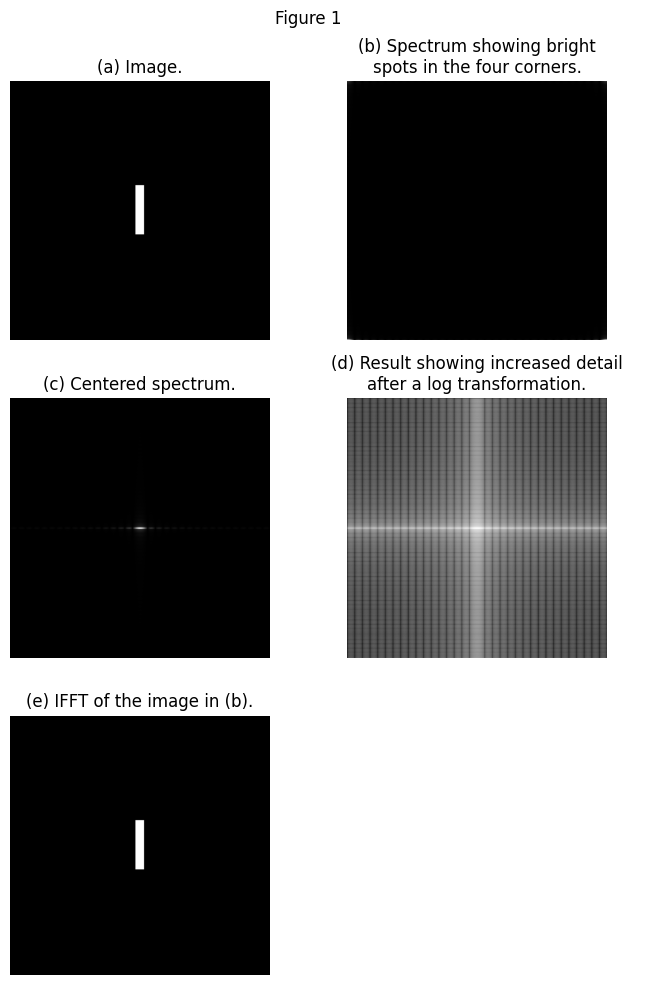

In [15]:
fig, ax = plt.subplots(3, 2, figsize=(7, 10))
ax[0, 0].axis("off"), ax[0, 1].axis("off"), ax[1, 0].axis("off"), ax[1, 1].axis("off"), ax[2, 0].axis("off"), ax[2, 1].axis("off")
ax[0, 0].imshow(data, cmap="gray"), ax[0, 1].imshow(np.abs(fft_data), cmap="gray")
ax[1, 0].imshow(np.abs(centered_fft_data), cmap="gray"), ax[1, 1].imshow(centered_fft_data_log_transformation, cmap="gray")
ax[2, 0].imshow(np.abs(ifft_data), cmap="gray")
ax[0, 0].set_title("(a) Image."), ax[0, 1].set_title("(b) Spectrum showing bright\nspots in the four corners.")
ax[1, 0].set_title("(c) Centered spectrum."), ax[1, 1].set_title("(d) Result showing increased detail\nafter a log transformation.")
ax[2, 0].set_title("(e) IFFT of the image in (b).")
fig.suptitle("Figure 1")
fig.tight_layout()
plt.show()

my2Dfft fonksiyonunda 2 boyutlu fourier dönüşümü alabilmek amacıyla pixel matrisinin önce satırlarının fourier dönüşümü alınmış sonrasında oluşan yeni pixel matrisi üzerinden transpose alınıp sütünlar satıra çevrilmiş ve fourier dönüşümü alındıktan sonra tekrar transpose alınarak 2 boyutlu fourier dönüşüm işlemi gerçekleştirilmiştir. Figure 1'de (a) daki orijinal resmin (b)'deki gibi 2 boyutlu fourier dönüşümü alınmış hali gösterilmektedir. (b) görselinde köşe noktalarda düşük frekanslı(0) değerler oluşmasından dolayı beyaz(255) olarak görünmektedir. Ayrıca, köşelerde oluşan değerler 0 frekanslı olmasından dolayı DC noktalarıdır. Buna karşın yüksek frekanslı(π) değer orta noktada (M/2, N/2) siyah olarak görünmektedir.

myDfft fonksiyonunun yaptığı işlemi my2Dft fonksiyonu ile yapılmaya çalışıldığında fonksiyonun gerçekleşme süreci myDfft fonksiyonuna kıyasla daha uzun sürmektedir. Bunun sebebi, myDfft fonksiyonu arka arkaya 2 kere fft fonkisyonunu "2N^2log2(N)" sürede gerçekleştirirken, my2Dft fonksiyonu "N^4" sürede gerçekleştirir. Bu nedenle, fonksiyon çalıştırıldığında 10 dakika beklenmesine rağmen herhangi bir sonuç alınamamıştır. 

Figure 1'deki (a) görüntüsünde DC noktası (0,0) noktasındadır. DC noktasını merkez(M/2, N/2) noktasına kaydırmak için orjinal görüntüdeki piksel verileri (—1)^(X+Y) ile çarpılmış, daha sonra 2 boyutlu fourier dönüşümü alınmıştır. Böylece (c) görseli elde edilmiş, (c) ve (b) görüntüleri kıyaslandığında ise yüksek frekanslı bileşenlerin uç noktalara, düşük frekanslı bileşenlerin orta noktada toplandığı görülmüştür.

Figure 1(d)'deki görselde (c) görselindeki pixel matrisinin logaritmik dönüşümü alınmış ve görseldeki renk aralığına bakılarak histogramlarındaki çoğu pixel değerinin 255 değerine yani beyaz renge yakın olduğu ayrıca düşük frekanslı hale geldiği gözlemlenmiştir.

sırasıyla aşağıdaki matematiksel işlemler, my2Difft fonksiyonunda yapılarak Figure 1(a)'daki görüntüden (e)'deki görüntü elde edilmiştir. Bu işlem sırasında fft'si alınan bileşenin konjugesi alınarak tekrar fft'si alınmış ve tekrar konjugesi alınarak toplam pixel sayısına bölünmüştür ve böylece myDifft fonksiyonundaki işlem gerçekleştirilmiştir.

F(u,v) = ∑[x=0,M-1] ∑[y=0,N-1] f(x,y)e^(-j2π(ux/M + vy/N))  
F'(u,v) = ∑[u=0,M-1] ∑[v=0,N-1] F*(u,v)e^(-j2π(ux/M + vy/N))  
f(x,y) = F'*(u,v)/MN = ∑[u=0,M-1] ∑[v=0,N-1] F(u,v)e^(j2π(ux/M + vy/N)) / MN  

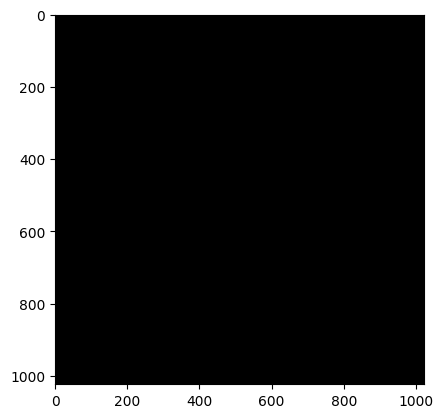

In [16]:
ifft_log_transform_data = my2Difft(np.array(centered_fft_data_log_transformation))
plt.imshow(np.abs(ifft_log_transform_data), cmap="gray")

Figure1(d) için yapılan açıklamaya göre logaritmik dönüşüm sonrası, görüntüdeki düşük frekanslı bileşenler ve yüksek frekanslı bileşenler arasındaki farkın azalmasına bağlı olarak pixel değerleri düşük frekans etrafında toplanmıştır. Burada yapılan logaritmik ölçekleme, pixellerde geri dönülemez bir vervi kaybına neden olmuş, bu nedenle (d)'deki görüntünün ters fourier transformu alındığında yukarıdaki görseldeki gibi (a) görüntüsü elde edilememiştir. 